# The Finite Element Method applied to the 1D Poisson Equation

In the following, we will solve the **Poisson equation** subject to **Dirichlet boundary conditions**, i.e. we want to find a function $u: \Omega \subset \mathbb{R}^d \to \mathbb{R}$, which fulfills

\begin{equation}
    \begin{cases}
        -\Delta u(x) = f(x) & \text{if } x \in \operatorname{int} \Omega \\
        u(x) = g(x)         & \text{if } x \in \partial \Omega,
    \end{cases}
\end{equation}

where $$\Delta := \sum_{i = 1}^D \frac{\partial}{\partial x_i}$$ is the **Laplace operator**.
For simplicity, we set $\Omega = [l, r] \subset \mathbb{R}$, which means that the problem reduces to

$$
    \begin{cases}
        -u''(x) = f(x) & \text{for } x \in (l, r) \\
        u(x) = g(x) & \text{for } x \in \{l, r\}
    \end{cases}
$$

We will use the **finite element method** (**FEM**) to solve the problem numerically.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import probnum as pn
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

In [2]:
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

In [3]:
# Define the domain \Omega = [l, r]
domain = (-1.0, 1.0)
(l, r) = domain

## Closed-form Solution in 1D for $f(x) = c$

The 1D Poisson problem can be solved by simply integrating the PDE and enforcing the boundary conditions afterwards.
We have

\begin{align*}
    \int_l^x \int_l^{\nu_2} -u''(\nu_1) \text{d}\nu_1 \text{d}\nu_2
    & = - \int_l^x (u'(\nu_2) - u'(l)) \text{d}\nu_2 \\
    & = - (u(x) - u(l)) + u'(l) (x - l) \\
    & = -u(x) + u(l) + u'(l) (x - l)
\end{align*}

and

\begin{align*}
    \int_l^x \int_l^{\nu_2} f(\nu_1) \text{d}\nu_1 \text{d}\nu_2
    & = c \int_l^x \int_l^{\nu_2} \text{d}\nu_1 \text{d}\nu_2 \\
    & = c \int_l^x (\nu_2 - l) \text{d}\nu_2 \\
    & = \frac{c}{2} (x^2 - l^2) - cl(x - l) \\
    & = \frac{c}{2} (x - l)(x + l) - cl(x - l).
\end{align*}

This means that

\begin{align*}
    & -u(x) + u(l) + u'(l) (x - l) = \frac{c}{2} (x - l)(x + l) - c l(x - l) \\
    \Leftrightarrow \quad
    & u(x) = u(l) + \left( u'(l) + c l - \frac{c}{2} (x + l) \right) (x - l).
\end{align*}

Obviously $u(l) = g(l)$.
However, we still need to find $u'(l)$.
This can be done by enforcing the right boundary condition:

\begin{align*}
    & g(r) \stackrel{!}{=} u(r) = g(l) + \left( u'(l) + c l - \frac{c}{2} (r + l) \right) (r - l) \\
    \Leftrightarrow \quad
    & u'(l) (r - l) = g(r) - g(l) - c l (r - l) + \frac{c}{2} (r + l) (r - l) \\
    \Leftrightarrow \quad
    & u'(l) = \frac{g(r) - g(l)}{r - l} - c l + \frac{c}{2} (r + l),
\end{align*}

All in all, we arrive at

\begin{align*}
    u(x)
    & = g(l) + \frac{g(r) - g(l)}{r - l} (x - l) + \frac{c}{2} (r + l - (x + l)) (x - l) \\
    & = g(l) + \frac{g(r) - g(l)}{r - l} (x - l) - \frac{c}{2} (x - r)(x - l).
\end{align*}

In [4]:
def poisson_1d_solution_constant_rhs(rhs, domain=(0.0, 1.0), boundary_values=(0.0, 0.0)):
    (l, r) = domain
    (g_l, g_r) = boundary_values
    
    aff_slope = (g_r - g_l) / (r - l)

    def u(x):
        return g_l + (aff_slope - (rhs / 2.0) * (x - r)) * (x - l)
    
    return u

In [5]:
u_zero_boundary = poisson_1d_solution_constant_rhs(
    rhs=2.0,
    domain=domain,
    boundary_values=(0.0, 0.0),
)

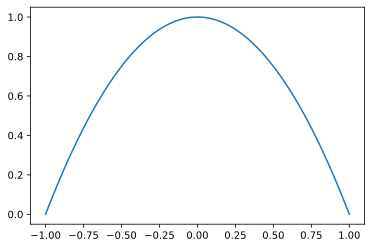

In [6]:
xs_plot = np.linspace(l, r, 100)

plt.plot(xs_plot, u_zero_boundary(xs_plot))
plt.show()

## Finite Element Solution for $g(x) = 0$

For the sake of simplicity, we will now assume that $g(x) = 0$ for $x \in \partial \Omega$.

### Step 1: Weak Formulation

To apply the finite element method, we must first convert the problem to its so-called **weak formulation**.

Let $V$ be a vector space of sufficiently smooth functions $\Omega \to \mathbb{R}$ with $v(x) = 0$ for all $v \in V$.
Note that a function $u \in V$ solves the problem above if and only if $\langle -\Delta u, v \rangle = \langle f, v \rangle$, or equivalently
$$-\int_\Omega \Delta u(x) v(x) \text{d}x = \int_\Omega f(x) v(x) \text{d}x$$
for every $v \in V$.
We can introduce additional symmetry to this formulation by applying Green's first identity to the left-hand side of the equation
$$-\int_\Omega \Delta u(x) v(x) \text{d}x = \int_\Omega \nabla u(x) \cdot \nabla v(x) \text{d}x - \int_{\partial \Omega} \underbrace{v(x)}_{= 0} (\nabla u(x) \cdot \mathbf{n}) \text{d}S = \int_\Omega \nabla u(x) \cdot \nabla v(x) \text{d}x.$$
This means that our original problem can be solved by finding a function $u \in V$ such that
$$\int_\Omega \nabla u(x) \nabla v(x) \text{d}x = \int_\Omega f(x) v(x) \text{d}x$$
for all $v \in V$.
This is commonly referred to as the weak formulation of the Poisson problem.

Note that we did not yet define the function space $V$ precisely.
In order to be able to write down the equations above, we require that the first (weak) derivatives of $u$ and $v$ are square integrable.
This means that an appropriate choice of $V$ is $V = H_0^1(\Omega)$, the Sobolev space of functions with square-integrable first (weak) derivatives which attain the value 0 on the boundary of $\Omega$.

In the 1D case, the integral equation simplifies to
$$\int_l^r u'(x) v'(x) \text{d}x = \int_l^r f(x) v(x) \text{d}x.$$

### Step 2: Discretization

Next, we convert the continuous problem above into a discrete problem by replacing $V$ with a finite-dimensional subspace $\hat{V} \subset V$.

#### The FEM Basis

In the one-dimensional finite element method, typically constucts $\hat{V}$ as follows:

The input domain $\Omega = [l, r]$ is discretized into a grid $(x_i)_{i = 1}^{n + 2}$ with $l = x_0 \le x_1 \le \dots \le x_{n + 1} = r$.

In [7]:
n = 9
grid = np.linspace(l, r, n + 2)

The grid can then be used to define a set of $n$ basis functions for $\hat{V}$:
$$
    \phi_i(x) :=
    \begin{cases}
        \frac{x - x_{i - 1}}{x_i - x_{i - 1}} & \text{if } x \in [x_{i - 1}, x_i] \\
        \frac{x_{i + 1} - x}{x_{i + 1} - x_i} & \text{if } x \in [x_i, x_{i + 1}] \\
        0 & \text{otherwise}
    \end{cases},
$$
where $i = 1, \dots, n$.
Note that this basis is constructed such that $\hat{V}$ only contains functions which directly fulfill the boundary conditions.

In [8]:
def plot_1d_fem_basis_zero_boundary(ax, grid, coords=None, **plot_kwargs):
    """Assumes an ordered grid"""
    if coords is None:
        coords = np.ones_like(grid[1:-1])
    
    xs = np.vstack((grid[:-2], grid[1:-1], grid[2:]))

    ys = np.empty_like(xs)
    ys[0, :] = 0.0
    ys[1, :] = coords
    ys[2, :] = 0.0

    ax.plot(xs, ys, **plot_kwargs)

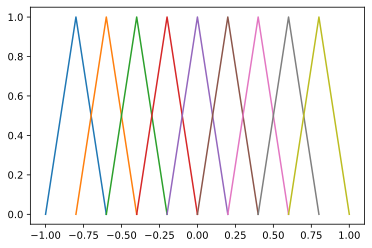

In [9]:
plot_1d_fem_basis_zero_boundary(plt.gca(), grid)

### Span of the FEM Basis

The function space spanned by this set of basis functions is given by
$$\hat{V} = \{ f_w := \sum_{i = 1}^n w_i \phi_i \mid w \in \mathbb{R}^n \}.$$

To see how $f_w$ behaves, let $x \in [x_k, x_{k + 1}]$ for $k = 1, \dots, n - 1$.
Then

\begin{align*}
    f_w(x)
    & = \sum_{i = 1}^n w_i \phi_i(x) \\
    & = \sum_{i = 1}^n w_i
    \begin{cases}
        \frac{x - x_{i - 1}}{x_i - x_{i - 1}} & \text{if } x \in [x_{i - 1}, x_i] \\
        \frac{x_{i + 1} - x}{x_{i + 1} - x_i} & \text{if } x \in [x_i, x_{i + 1}] \\
        0 & \text{otherwise}
    \end{cases}
    \\
    & = w_k \frac{x_{k + 1} - x}{x_{k + 1} - x_k} + w_{k + 1} \frac{x - x_{(k + 1) - 1}}{x_{k + 1} - x_{(k + 1) - 1}} \\
    & = \frac{x_{k + 1} - x_k + x_k - x}{x_{k + 1} - x_k} w_k + \frac{x - x_k}{x_{k + 1} - x_k} w_{k + 1} \\
    & = \left( 1 - \frac{x - x_k}{x_{k + 1} - x_k} \right) w_k + \frac{x - x_k}{x_{k + 1} - x_k} w_{k + 1}.
\end{align*}

We can see that $f_w$ attains value $w_i$ at grid point $i$ and it interpolates linearly in between grid points.

In [10]:
def fem_zero_boundary_coords_to_fn(grid, coords):
    ys_grid = np.empty_like(coords, shape=(grid.shape[0],))
    ys_grid[0] = 0.0
    ys_grid[1:-1] = coords
    ys_grid[-1] = 0.0

    return lambda x: np.interp(x, grid, ys_grid)

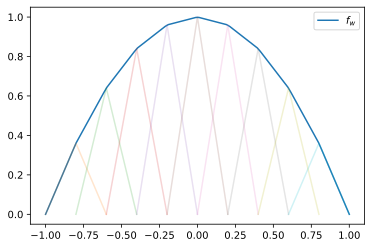

In [11]:
w = u_zero_boundary(grid[1:-1])

xs_plot = np.linspace(l, r, 100)

plt.plot(xs_plot, fem_zero_boundary_coords_to_fn(grid, w)(xs_plot), label="$f_w$")
plot_1d_fem_basis_zero_boundary(plt.gca(), grid, coords=w, alpha=0.2)
plt.legend()
plt.show()

### Weak Formulation of the Poisson Problem in the FEM basis

We can now express $u$ in the weak formulation by its basis expansion
$$u(x) = \sum_{j = 1}^n \hat{u}_j \phi_j(x),$$
i.e.
$$u'(x) = \sum_{j = 1}^n \hat{u}_j \phi_j'(x).$$
This means that we now need to find the coefficients $u_i$ such that
$$\sum_{j = 1}^n \hat{u}_j \int_l^r \phi_j'(x) v'(x) \text{d}x = \int_l^r f(x) v(x) \text{d}x$$
for all $v \in \hat{V}$.
Since the equation is linear in $v$, this is equivalent to solving the system of equations
$$\sum_{j = 1}^n \hat{u}_j \int_l^r \phi_j'(x) \phi_i'(x) \text{d}x = \int_l^r f(x) \phi_i(x) \text{d}x,$$
where $j = 1, \dots, n$ for the coeffients $\hat{u}_i$.

If we define a matrix $A \in \mathbb{R}^{n \times n}$ with
$$A_{ij} := \int_l^r \phi_i'(x) \phi_j'(x) \text{d}x,$$
and a vector $b \in \mathbb{R}^n$, where
$$b_i := \int_l^r \phi_i(x) f(x) \text{d}x,$$
we can equivalently write the weak formulation on $\hat{V}$ as
$$(A \hat{u})_i = \sum_{j = 1}^n \left( \int_l^r \phi_i'(x) \phi_j'(x) \text{d}x \right) \hat{u}_j = \int_l^r f(x) \phi_i(x) \text{d}x = b_i.$$
Hence, we have now reduced our original continuous Poisson problem to a linear system $A \hat{u} = b$.

### Computing Closed-form Expressions for $A$ and $b$

We will now compute closed-form expressions for the entries of $A$.
First of all, note that $A$ is symmetric.
Moreover, we have
$$
    \phi_i'(x) =
    \begin{cases}
        \frac{1}{x_i - x_{i - 1}}, & \text{if } x \in [x_i - x_{i - 1}] \\
        -\frac{1}{x_{i + 1} - x_i}, & \text{if } x \in [x_{i + 1} - x_i] \\
        0, & \text{otherwise}
    \end{cases}
$$
(in the weak sense).
This implies that $A_{ij} = 0$ for $j \notin \{ i - 1, i, i + 1 \}$, since the support of $\phi_i'$ only overlaps with the support of $\phi_j'$ for $j \in \{ i - 1, i, i + 1 \}$.
Hence, $A$ is tridiagonal.

Consequently, we only need to compute $A_{ii}$ for $i = 1, \dotsc, n$, and $A_{i,i+1}$ for $i = 1, \dots, n - 1$.

\begin{align*}
    A_{ii}
    & := \int_l^r (\phi_i'(x))^2 \text{d}x \\
    & = \int_{x_{i - 1}}^{x_i} \left( \frac{1}{x_i - x_{i - 1}} \right)^2 \text{d}x + \int_{x_i}^{x_{i + 1}} \left( -\frac{1}{x_{i + 1} - x_i} \right)^2 \text{d}x \\
    & = \frac{1}{(x_i - x_{i - 1})^2} \int_{x_{i - 1}}^{x_i} \text{d}x + \frac{1}{(x_{i + 1} - x_i)^2} \int_{x_i}^{x_{i + 1}} \text{d}x \\
    & = \frac{x_i - x_{i - 1}}{(x_i - x_{i - 1})^2} + \frac{x_{i + 1} - x_i}{(x_{i + 1} - x_i)^2} \\
    & = \frac{1}{x_i - x_{i - 1}} + \frac{1}{x_{i + 1} - x_i}
\end{align*}

\begin{align*}
    A_{i,i + 1}
    & := \int_l^r \phi_i'(x) \phi_{i + 1}'(x) \text{d}x \\
    & = \int_{x_{i - 1}}^{x_i} \frac{1}{x_i - x_{i - 1}} \cdot 0 \text{d}x \\
    \qquad & + \int_{x_i}^{x_{i + 1}} \left( -\frac{1}{x_{i + 1} - x_i} \right) \left( \frac{1}{x_{i + 1} - x_i} \right) \text{d}x \\
    \qquad & + \int_{x_{i + 1}}^{x_{i + 2}} 0 \cdot \left( -\frac{1}{x_{i + 1} - x_i} \right) \text{d}x \\
    & = -\frac{1}{(x_{i + 1} - x_i)^2} \int_{x_i}^{x_{i + 1}} \text{d}x \\
    & = -\frac{x_{i + 1} - x_i}{(x_{i + 1} - x_i)^2} \\
    & = -\frac{1}{x_{i + 1} - x_i}
\end{align*}

In [12]:
def poisson_1d_zero_boundary_operator_fem(grid: np.ndarray) -> pn.linops.Matrix:
    # Diagonal
    diag = 1 / (grid[1:-1] - grid[:-2])
    diag += 1 / (grid[2:] - grid[1:-1])

    # Off-Diagonals
    offdiag = -1.0 / (grid[2:-1] - grid[1:-2])
    
    return pn.linops.Matrix(
        scipy.sparse.diags(
            (offdiag, diag, offdiag),
            offsets=(-1, 0, 1),
            format="csr",
            dtype=np.double,
        )
    )

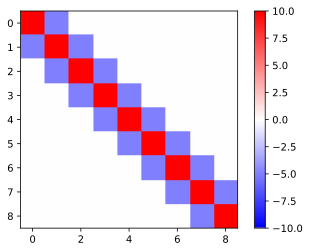

In [13]:
A = poisson_1d_zero_boundary_operator_fem(grid)

# Plot a heatmap of the matrix
vmax = np.max(np.abs(A.todense()))

plt.imshow(A.todense(), cmap="bwr", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In order to find a closed-form expression for the right-hand side, we either need to fix a closed-form representation of $f$ or revert to quadrature algorithms.

For the sake of simplicity, we will assume $f(x) = c \in \mathbb{R}$ in the following.
In this case, the entries of $b$ are given by

\begin{align*}
    b_i
    & = \int_l^r f(x) \phi_i(x) \text{d}x \\
    & = c \int_l^r \phi_i(x) \text{d}x \\
    & = c \left( \int_{x_{i - 1}}^{x_i} \frac{x - x_{i - 1}}{x_i - x_{i - 1}} \text{d}x + \int_{x_i}^{x_{i + 1}} \frac{x_{i + 1} - x}{x_{i + 1} - x_i} \text{d}x \right) \\
    & = c \left( \frac{1}{x_i - x_{i - 1}} \int_{x_{i - 1}}^{x_i} x - x_{i - 1} \text{d}x + \frac{1}{x_{i + 1} - x_i} \int_{x_i}^{x_{i + 1}} x_{i + 1} - x \text{d}x \right) \\
    & = c \left( \frac{1}{x_i - x_{i - 1}} \int_0^{x_i - x_{i - 1}} x \text{d}x + \frac{1}{x_{i + 1} - x_i} \int_{x_{i + 1} - x_i}^0 x \cdot (-1) \text{d}x \right) \\
    & = c \left( \frac{1}{x_i - x_{i - 1}} \left( \frac{1}{2} x^2 \bigg \rvert_0^{x_i - x_{i - 1}} \right) - \frac{1}{x_{i + 1} - x_i} \left( \frac{1}{2} x^2 \bigg \rvert_{x_{i + 1} - x_i}^0 \right) \right) \\
    & = \frac{c}{2} \left( \frac{(x_i - x_{i - 1})^2}{x_i - x_{i - 1}} + \frac{(x_{i + 1} - x_i)^2}{x_{i + 1} - x_i} \right) \\
    & = \frac{c}{2} (x_i - x_{i - 1} + (x_{i + 1} - x_i)) \\
    & = \frac{c}{2} (x_{i + 1} - x_{i - 1}).
\end{align*}

In [14]:
c = 2.0

In [15]:
def poisson_1d_rhs_fem(rhs: float, grid: np.ndarray) -> np.ndarray:
    if isinstance(rhs, float):
        return (rhs / 2) * (grid[2:] - grid[:-2])
    else:
        raise TypeError

In [16]:
b = poisson_1d_rhs_fem(c, grid)
b

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

### Step 3: Solving the Linear System

In the final step of the finite element method, we need to solve the linear system $A \hat{u} = b$, where $A$ and $b$ are defined as above.

In [17]:
A = poisson_1d_zero_boundary_operator_fem(grid)
b = poisson_1d_rhs_fem(c, grid)

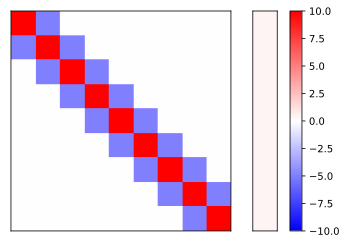

In [18]:
fig, axes = plt.subplots(
    ncols=3,
    figsize=(5, 3.5),
    gridspec_kw={
        "width_ratios": [4, 0.75, .2]
    },
)

vmax = np.max(np.abs(np.hstack([A.todense(), b[:, None]])))

img = axes[0].imshow(A.todense(), cmap="bwr", vmin=-vmax, vmax=vmax)
axes[1].imshow(b[:, None], cmap="bwr", vmin=-vmax, vmax=vmax)
fig.colorbar(img, cax=axes[2])

for ax in axes[:-1]:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

The system matrix $A$ is sparse which means that we can benefit from a sparse solver like the method of **conjugate gradients**.

In [19]:
u_zero_boundary_fem_coords, _ = scipy.sparse.linalg.cg(A.A, b)

In [20]:
u_zero_boundary_fem = fem_zero_boundary_coords_to_fn(grid, u_zero_boundary_fem_coords)

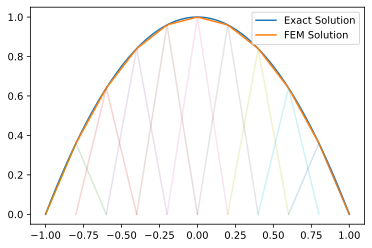

In [21]:
xs_plot = np.linspace(l, r, 100)

plt.plot(xs_plot, u_zero_boundary(xs_plot), label="Exact Solution")
plt.plot(xs_plot, u_zero_boundary_fem(xs_plot), label="FEM Solution")
plot_1d_fem_basis_zero_boundary(plt.gca(), grid, coords=u_zero_boundary_fem_coords, alpha=0.2)
plt.legend()
plt.show()

## Finite Element Solution for Non-zero Boundary Conditions

In [22]:
boundary_values = (-1.2, 0.75)

In [23]:
def discrete_poisson_problem_with_boundary_conditions(grid):
    (N,) = grid.shape
    
    diag = np.empty_like(grid)
    offdiag = np.empty_like(grid, shape=(N - 1,))

    # Laplace Operator on the interior
    diag[1:-1] = (  
        1 / (grid[1:-1] - grid[:-2])
        + 1 / (grid[2:] - grid[1:-1])
    )
    offdiag[1:-1] = -1.0 / (grid[2:-1] - grid[1:-2])
    
    # Left boundary condition
    diag[0] = 1.0
    offdiag[0] = 0.0
    
    # Right boundary condition
    diag[-1] = 1.0
    offdiag[-1] = 0.0
    
    return pn.linops.Matrix(
        scipy.sparse.diags(
            (offdiag, diag, offdiag),
            offsets=(-1, 0, 1),
            format="csr",
            dtype=grid.dtype,
        )
    )

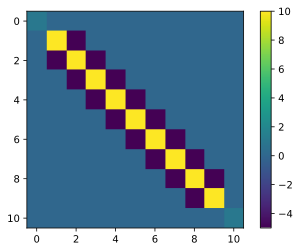

In [24]:
plt.imshow(discrete_poisson_problem_with_boundary_conditions(grid).todense())
plt.colorbar()

In [25]:
def discrete_poisson_problem_with_boundary_conditions_rhs(grid, alpha, boundary_values):
    rhs = np.empty_like(grid)
    
    l, r = boundary_values
    
    rhs[1:-1] = (alpha / 2) * (grid[2:] - grid[:-2])
    
    # Left Boundary Condition
    rhs[0] = l
    rhs[1] += l / (grid[2] - grid[1])
    
    # Right Boundary Condition
    rhs[-1] = r
    rhs[-2] += r / (grid[-2] - grid[-3])

    return rhs

In [26]:
discrete_poisson_problem_with_boundary_conditions_rhs(grid, 1.0, boundary_values=boundary_values)

array([-1.2 , -5.8 ,  0.2 ,  0.2 ,  0.2 ,  0.2 ,  0.2 ,  0.2 ,  0.2 ,
        3.95,  0.75])

In [27]:
def discrete_poisson_problem_with_boundary_conditions_sol(grid, boundary_values):
    A = discrete_poisson_problem_with_boundary_conditions(grid)
    b = discrete_poisson_problem_with_boundary_conditions_rhs(grid, 2.0, boundary_values=boundary_values)

    (u, _) = scipy.sparse.linalg.cg(A.A, b)
    
    return u

In [28]:
sol = discrete_poisson_problem_with_boundary_conditions_sol(grid, boundary_values)

In [29]:
sol

array([-1.2  , -0.645, -0.17 ,  0.225,  0.54 ,  0.775,  0.93 ,  1.005,
        1.   ,  0.915,  0.75 ])

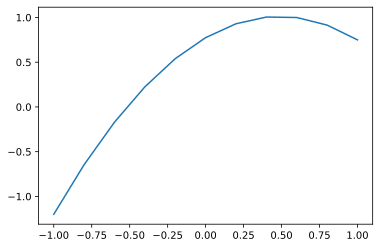

In [30]:
plt.plot(grid, sol)

### Comparison with clean implementation

In [31]:
import probnum_galerkin

In [32]:
bvp = probnum_galerkin.problems.PoissonEquation(
    domain=domain,
    rhs=2.0,
    boundary_condition=probnum_galerkin.problems.DirichletBoundaryCondition(
        domain,
        boundary_values,
    ),
)

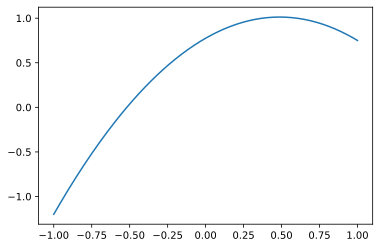

In [33]:
xs_plot = np.linspace(l, r, 200)

plt.plot(xs_plot, bvp.solution(xs_plot))

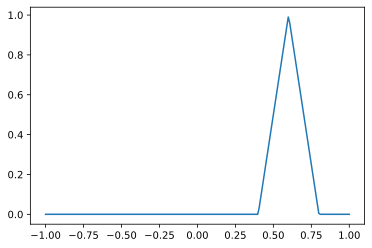

In [34]:
basis = probnum_galerkin.bases.FiniteElementBasis(
    domain=domain,
    num_elements=n,
)

plt.plot(xs_plot, basis[-3](xs_plot))

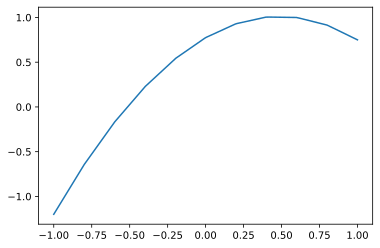

In [35]:
plt.plot(xs_plot, basis.coords2fn(bvp.solution(basis._grid))(xs_plot))

array([-1.2 , -5.6 ,  0.4 ,  0.4 ,  0.4 ,  0.4 ,  0.4 ,  0.4 ,  0.4 ,
        4.15,  0.75])

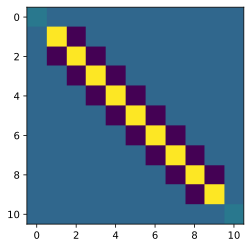

In [36]:
linsys = bvp.discretize(basis)

plt.imshow(linsys.A.todense())

linsys.b

## 1D Fourier Basis Functions

In [ ]:
def fourier_basis_element_1d(x, n, domain=(-1.0, 1.0)):
    return np.sin(n * np.pi * (x - domain[0]) / (domain[1] - domain[0]))

In [ ]:
def plot_1d_fourier_basis_functions(n_funcs: int, domain=(-1.0, 1.0)):
    grid = np.linspace(domain[0], domain[1], 100)
    
    for n in range(1, n_funcs + 1):
        plt.plot(grid, fourier_basis_element_1d(grid, n, domain))

In [ ]:
plot_1d_fourier_basis_functions(5)

In [ ]:
def coeffs_to_solution(coeffs, domain=(-1.0, 1.0)):
    ns = np.arange(1, coeffs.size + 1)

    def _sol(grid):
        sol = fourier_basis_element_1d(  # shape: (G, N)
            grid[:, None],
            ns[None, :],
            domain,
        )
        sol *= coeffs
        
        return np.sum(sol, axis=-1)
    
    return _sol

In [ ]:
grid = np.linspace(-1.0, 1.0, 100)

plt.plot(
    grid,
    coeffs_to_solution(np.array([-4.0, 1.0, 2.0, 2.0, 1.0]))(grid)
)

## Approximate Laplace Operator in the Fourier Basis

In [ ]:
def discrete_1d_fourier_laplace(N: int, domain=(-1.0, 1.0)):
    a, b = domain
    Ns = np.arange(1, N + 1)

    return pn.linops.Matrix(
        scipy.sparse.diags(
            Ns * np.pi / (4 * (b - a)) * ((2 * np.pi) * Ns + np.sin((2 * np.pi) * Ns)),
            offsets=0,
            format="csr",
            dtype=np.double,
        )
    )

In [ ]:
discrete_1d_fourier_laplace(6)

In [ ]:
plt.imshow(discrete_1d_fourier_laplace(6).todense())
plt.show()

## Approximate RHS in the Fourier Basis

In [ ]:
def discrete_1d_fourier_rhs(alpha, N: int, domain=(-1.0, 1.0)):
    a, b = domain
    Ns = np.arange(1, N + 1)

    return alpha * (b - a) / np.pi * (1 - np.cos(np.pi * Ns)) / Ns

In [ ]:
discrete_1d_fourier_rhs(1.0, 6)

## Solution

In [ ]:
def discrete_1d_fourier_solve(N: int, domain=(-1.0, 1.0)):
    A = discrete_1d_fourier_laplace(N, domain)
    b = discrete_1d_fourier_rhs(2.0, N, domain)

    (coeffs, _) = scipy.sparse.linalg.cg(-A.A, b)
    
    return coeffs

In [ ]:
coeffs = discrete_1d_fourier_solve(N=3)
sol = coeffs_to_solution(coeffs)

In [ ]:
coeffs

In [ ]:
grid = np.linspace(-1.0, 1.0, 100)

plt.plot(grid, sol(grid))

# Probabilistic Numerical Solution of the Linear System
\begin{equation}
    \renewcommand{\vec}[1]{\mathbf{#1}}
    \newcommand{\inprod}[2]{\left\langle #1, #2 \right\rangle}
    \newcommand{\norm}[1]{\left\lVert #1 \right\rVert}
\end{equation}

We now solve the linear system $A x = b$ using a solution-based probabilistic linear solver.
This essentially boils down to online inference in a linear Gaussian model.
We assume that we have a prior $$p(x) = \mathcal{N}(x; \mu_0, \Sigma_0)$$ over the solution of the linear system.
In each iteration of the solver, we collect information about the solution by projecting onto a one dimensional subspace defined by $s_i$: $$y_i := s_i^T b = (s_i^T A) x.$$
Let $S_m := \begin{pmatrix} s_1, \dots, s_m \end{pmatrix}$ and $\vec{y}_m := \begin{pmatrix} y_1, \dots, y_m \end{pmatrix}^T$.
We can now infer $x$ using the Dirac likelihood $$p(y \mid x) = \delta(\vec{y}_m - S_m^T A x).$$
Since this is an observation of a linear function of $x$, we can perform inference in closed form.
The posterior for step $m$ is then given by $$p(x \mid y) = \mathcal{N}(x; \mu_m, \Sigma_m),$$ with
\begin{align}
    \mu_m & := \mu_0 + \Sigma_0 A^T S_m \Lambda_m^{-1} S_m^T r_0 \\
    \Sigma_m & := \Sigma_0 - \Sigma_0 A^T S_m \Lambda_m^{-1} S_m^T A \Sigma_0,
\end{align}
where $r_0 := b - A \mu_0$ is the initial residual and $\Lambda_m := S_m^T A \Sigma_0 A^T S_m$.

To keep inference tractable, we must choose $S_m$ such that $\Lambda_m$ is diagonal.
This can be achieved by considering $A \Sigma_0 A^T$-orthonormal search directions, i.e. $\inprod{s_i}{s_j}_{A \Sigma_0 A^T} = \delta_{ij}$. In this case, we have $(\Lambda_m)_{i,j} = \delta_{ij}$ and thus
\begin{align}
    \mu_m
    & = \mu_0 + \Sigma_0 A^T S_m S_m^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T \sum_{i = 1}^m s_i s_i^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T \sum_{i = 1}^{m - 1} s_i s_i^T r_0 + \Sigma_0 A^T s_m s_m^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T S_{m - 1} S_{m - 1}^T r_0 + \Sigma_0 A^T s_m (s_m^T b - s_m^T A \mu_0) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m (s_m^T b - s_m^T A \mu_0 - \underbrace{s_m^T A \Sigma_0 A^T S_{m - 1}}_{= 0} S_{m - 1}^T r_0) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m s_m^T (b - A (\mu_0 + \Sigma_0 A^T S_{m - 1} S_{m - 1}^T r_0)) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m s_m^T \underbrace{(b - A \mu_{m - 1})}_{=: r_{m - 1}}
\end{align}

and

\begin{align}
    \Sigma_m
    & = \Sigma_0 - \Sigma_0 A^T S_m S_m^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T \sum_{i = 1}^m s_i s_i^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T \sum_{i = 1}^{m - 1} s_i s_i^T A \Sigma_0 - \Sigma_0 A^T s_i s_i^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T S_{m - 1} S_{m - 1}^T A \Sigma_0 - \Sigma_0 A^T s_i (\Sigma_0 A^T s_i)^T \\
    & = \Sigma_{m - 1} - \Sigma_0 A^T s_i (\Sigma_0 A^T s_i)^T.
\end{align}

We can generate $A \Sigma_0 A^T$-orthonormal search directions $s_m$ on-the-fly as in CG, i.e. $s_m = \frac{\tilde{s}_m}{\norm{\tilde{s}_m}_{A \Sigma_0 A^T}}$, $\tilde{s}_1 = r_0$ and

\begin{align}
    \tilde{s}_m = r_{m - 1} - \inprod{s_{m - 1}}{r_{m - 1}}_{A \Sigma_0 A^T} s_{m - 1}
\end{align}

In [ ]:
from typing import Callable, Optional, Union


def problinsolve(
    A: pn.linops.LinearOperatorLike,
    b: np.ndarray,
    prior_x: Optional[Union[pn.randvars.Normal, np.ndarray]] = None,
    auto_cov_type: str = "cg",
    max_num_steps: Optional[int] = None,
    rtol: float = 1e-5,
    atol: float = 1e-5,
    callback: Callable[..., None] = None,
):
    A = pn.linops.aslinop(A)
    
    # Prior construction
    if isinstance(prior_x, pn.randvars.Normal):
        x0 = prior_x.mean.astype(np.result_type(A.dtype, b.dtype), copy=True)
        cov0 = prior_x.cov.astype(x0.dtype, copy=True)
    else:
        if isinstance(prior_x, np.ndarray):
            x0 = prior_x.astype(np.result_type(A.dtype, b.dtype), subok=True, copy=True)
        else:
            assert prior_x is None

            x0 = np.zeros(A.shape[1], np.result_type(A.dtype, b.dtype))
            
        if auto_cov_type == "id":
            cov0 = np.eye(x0.size, dtype=x0.dtype)
        elif auto_cov_type == "cg":
            cov0 = A.inv()
        
    # Stopping Criteria
    if max_num_steps is None:
        max_num_steps = 10 * x0.size
        
    res_norm_thresh = np.maximum(rtol * np.linalg.norm(b), atol)
    
    # Callback
    if callback is None:
        callback = lambda **kwargs: None
    
    # Initialization
    step_idx = 0
    
    x = x0
    cov = cov0
    
    residual = b - A @ x
    residual_norm_sq = np.inner(residual, residual)
    residual_norm = np.sqrt(residual_norm_sq)
    
    stop = (
        step_idx >= max_num_steps
        or residual_norm < res_norm_thresh
    )
    
    callback(
        step_idx=step_idx,
        x=pn.randvars.Normal(mean=x.copy(), cov=cov),
        residual=residual.copy(),
        residual_norm_sq=residual_norm_sq,
        residual_norm=residual_norm,
        stop=stop,
        action=None,
        observation=None,
        stepdir=None,
        stepsize=None,
    )
    
    action = residual
    
    # Iteration
    prev_residual = None
    prev_residual_norm_sq = None
    
    while not stop:
        observation = np.inner(action, residual)
        
        matvec = A @ action
        
        # Update solution
        stepdir = cov @ matvec
        
        gram = np.inner(matvec, stepdir)
        # gram_pinv = 1.0 / gram if gram >= 12 ** -7 else 0.0
        gram_pinv = 1.0 / gram
        
        stepsize = gram_pinv * observation
        
        x += stepsize * stepdir
        cov -= np.outer(stepdir, stepdir) * gram_pinv
        
        # Update residual
        prev_residual = residual
        prev_residual_norm_sq = residual_norm_sq

        residual = b - A @ x
        residual_norm_sq = np.inner(residual, residual)
        residual_norm = np.sqrt(residual_norm_sq)
        
        # Check stopping criteria
        step_idx += 1
        
        stop = (
            step_idx >= max_num_steps
            or residual_norm < res_norm_thresh
        )
        
        # Callback
        callback(
            step_idx=step_idx,
            x=pn.randvars.Normal(mean=x.copy(), cov=cov),
            residual=residual,
            residual_norm=residual_norm,
            stop=stop,
            action=action,
            observation=observation,
            stepdir=stepdir,
            stepsize=stepsize,
        )

        # Apply stopping criteria
        if stop:
            break
        
        # Update action
        action = residual + (residual_norm_sq / prev_residual_norm_sq) * action
    
    return pn.randvars.Normal(
        mean=x,
        cov=cov,
    )

In [ ]:
from typing import Callable, Optional, Union


def bayescg(
    A: pn.linops.LinearOperatorLike,
    b: np.ndarray,
    prior_x: Optional[Union[pn.randvars.Normal, np.ndarray]] = None,
    auto_cov_type: str = "cg",
    max_num_steps: Optional[int] = None,
    rtol: float = 1e-5,
    atol: float = 1e-5,
    callback: Callable[..., None] = None,
):
    A = pn.linops.aslinop(A)
    
    # Prior construction
    if isinstance(prior_x, pn.randvars.Normal):
        x0 = prior_x.mean.astype(np.result_type(A.dtype, b.dtype), copy=True)
        cov0 = prior_x.cov.astype(x0.dtype, copy=True)
    else:
        if isinstance(prior_x, np.ndarray):
            x0 = prior_x.astype(np.result_type(A.dtype, b.dtype), subok=True, copy=True)
        else:
            assert prior_x is None

            x0 = np.zeros(A.shape[1], np.result_type(A.dtype, b.dtype))
            
        if auto_cov_type == "id":
            cov0 = np.eye(x0.size, dtype=x0.dtype)
        elif auto_cov_type == "cg":
            cov0 = A.inv()
            
    cov0 = pn.linops.aslinop(cov0)
        
    # Stopping Criteria
    if max_num_steps is None:
        max_num_steps = 10 * x0.size
        
    res_norm_thresh = np.maximum(rtol * np.linalg.norm(b), atol)
    
    # Callback
    if callback is None:
        callback = lambda **kwargs: None
    
    # Initialization
    step_idx = 0
    
    x = x0
    cov = cov0
    
    nu = 0.0
    cov_scale = 0.0
    
    residual = b - A @ x
    residual_norm_sq = np.inner(residual, residual)
    residual_norm = np.sqrt(residual_norm_sq)
    
    stop = (
        step_idx >= max_num_steps
        or residual_norm < res_norm_thresh
    )
    
    callback(
        step_idx=step_idx,
        x=pn.randvars.Normal(mean=x0.copy(), cov=cov0),
        residual=residual.copy(),
        residual_norm_sq=residual_norm_sq,
        residual_norm=residual_norm,
        stop=stop,
        action=None,
        stepdir=None,
        stepsize=None,
    )
    
    # Iteration
    action = residual
    matvec = A @ action
    
    prev_residual = None
    prev_residual_norm_sq = None
    
    prev_actions = []
    prev_matvecs = []
    
    while not stop:
        # Update solution
        stepdir = cov0 @ matvec  # Sigma0 @ A @ s
        
        gram = np.inner(matvec, stepdir)  # s @ A @ Sigma0 @ A @ s
        gram_pinv = 1.0 / gram if gram >= 10 ** -5 else 0.0
        # gram_pinv = 1.0 / gram
        
        stepsize = gram_pinv * residual_norm_sq  # 
        
        x += stepsize * stepdir
        cov -= np.outer(stepdir, stepdir) * gram_pinv
        
        step_idx += 1
        
        nu += residual_norm_sq * gram_pinv
        cov_scale = nu / step_idx
        
        # Update residual
        prev_residual = residual
        prev_residual_norm_sq = residual_norm_sq

        residual = b - A @ x
        residual_norm_sq = np.inner(residual, residual)
        residual_norm = np.sqrt(residual_norm_sq)
        
        # Check stopping criteria
        stop = (
            step_idx >= max_num_steps
            or residual_norm < res_norm_thresh
        )
        
        # Callback
        callback(
            step_idx=step_idx,
            x=pn.randvars.Normal(mean=x.copy(), cov=cov_scale * cov),
            # x=pn.randvars.Normal(mean=x.copy(), cov=cov),
            cov_scale=cov_scale,
            residual=residual,
            residual_norm=residual_norm,
            stop=stop,
            action=action,
            stepdir=stepdir,
            stepsize=stepsize,
        )

        # Apply stopping criteria
        if stop:
            break
        
        # Update action
        prev_actions.append(action)
        prev_matvecs.append(matvec)
        
        action = residual + (residual_norm_sq / prev_residual_norm_sq) * action
        matvec = A @ action
        
        # Reorthogonalize
        for prev_action, prev_matvec in zip(prev_actions, prev_matvecs):
            action -= (np.inner(prev_matvec, cov0 @ matvec) / np.inner(prev_matvec, cov0 @ prev_matvec)) * prev_action
    
    return pn.randvars.Normal(
        mean=x,
        cov=cov_scale * cov,
    )

In [ ]:
M = np.random.randn(10, 10)
A = M @ M.T + np.eye(10)
b = np.random.randn(10)

In [ ]:
np.linalg.solve(A, b)

In [ ]:
sol = bayescg(A, b)
sol.mean, sol.var

In [ ]:
def discrete_1d_laplace_solve_bayescg(grid: np.ndarray, **bayescg_kwargs) -> pn.randvars.Normal:
    A = discrete_1d_laplace_operator(grid)
    b = discrete_1d_laplace_rhs(grid, 2.0)

    u_no_boundary = bayescg(A, -b, **bayescg_kwargs)
    
    u_mean = np.empty_like(u_no_boundary.mean, shape=(u_no_boundary.size + 2,))
    u_mean[0] = 0.0
    u_mean[1:-1] = u_no_boundary.mean
    u_mean[-1] = 0.0
    
    u_cov = np.empty_like(u_no_boundary.mean, shape=(u_no_boundary.size + 2, u_no_boundary.size + 2))
    u_cov[0, :] = 0
    u_cov[-1, :] = 0
    u_cov[:, 0] = 0
    u_cov[:, -1] = 0
    u_cov[1:-1, 1:-1] = u_no_boundary.cov.todense()
    
    return pn.randvars.Normal(u_mean, u_cov)

In [ ]:
u = discrete_1d_laplace_solve_bayescg(grid, max_num_steps=10, rtol=0, atol=0)

In [ ]:
plt.plot(grid, u.mean)
plt.fill_between(grid, u.mean - 2 * u.var, u.mean + 2 * u.var, alpha=0.1)

In [ ]:
from matplotlib import animation

def animate_bayescg_poisson_fem(**bayescg_kwargs):
    N = grid.size
    
    # Run the algorithm and log step statistics
    step_stats = []
    step_residual_norms = []
    step_cov_traces = []

    def _callback(x: pn.randvars.Normal, residual_norm: np.ndarray, **kwargs):
        u_mean = np.empty_like(x.mean, shape=(x.size + 2,))
        u_mean[0] = 0.0
        u_mean[1:-1] = x.mean.copy()
        u_mean[-1] = 0.0

        u_std = np.empty_like(x.mean, shape=(x.size + 2,))
        u_std[0] = 0.0
        u_std[1:-1] = np.sqrt(np.maximum(x.var, 0.0))
        u_std[-1] = 0.0

        step_stats.append((u_mean, u_std))
        step_residual_norms.append(residual_norm)
        step_cov_traces.append(np.mean(x.var))

    discrete_1d_laplace_solve_bayescg(
        grid,
        max_num_steps=N - 2,
        callback=_callback,
        **bayescg_kwargs
    )

    fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
    plt.close()

    def animate(step_idx):
        ax[0].cla()
        ax[1].cla()

        mean, std = step_stats[step_idx]

        fig.suptitle(f"1D Poisson - FEM (N = {N}) - BayesCG - Iteration {step_idx:03d}")

        ax[0].set_title("Solution")
        ax[0].set_ylim(-1.3, np.max(mean + 2 * std) + 0.1)
        ax[0].plot(grid, mean)
        ax[0].fill_between(grid, mean - 2 * std, mean + 2 * std, alpha=0.2)

        ax[1].set_title("Stopping Criteria")
        ax[1].plot(step_residual_norms[:step_idx + 1], "C0", label="residual norm")
        # ax[1].plot(step_cov_traces[:step_idx + 1], "C0", label="cov trace")
        ax[1].legend(loc="upper right")
        ax[1].set_xlabel("Iterations")

    return animation.FuncAnimation(
        fig,
        func=animate,
        frames=len(step_stats),
        interval=200,
        repeat_delay=4000,
        blit=False,
    )

In [ ]:
from IPython.display import HTML

anim = animate_bayescg_poisson_fem()

HTML(anim.to_jshtml())

In [ ]:
anim.save("../results/fem_probsolve.gif", animation.PillowWriter(fps=5))

In [ ]:
def discrete_1d_fourier_solve_bayescg(N: int, domain=(-1.0, 1.0), **bayescg_kwargs):
    A = discrete_1d_fourier_laplace(N, domain)
    b = discrete_1d_fourier_rhs(2.0, N, domain)
    
    return bayescg(-A, b, **bayescg_kwargs)

def coeffs_to_prob_solution(coeffs: pn.randvars.Normal, domain=(-1.0, 1.0)):
    ns = np.arange(1, coeffs.size + 1)

    def _sol(grid):
        basis = fourier_basis_element_1d(  # shape: (G, N)
            grid[:, None],
            ns[None, :],
            domain,
        )
        
        return basis @ coeffs
    
    return _sol

In [ ]:
coeffs = discrete_1d_fourier_solve_bayescg(10)
sol = coeffs_to_prob_solution(coeffs)

coeffs.mean, coeffs.var

In [ ]:
sol_grid = sol(grid)

plt.plot(grid, sol_grid.mean, color="C1")
plt.fill_between(grid, sol_grid.mean - 2 * sol_grid.var, sol_grid.mean + 2 * sol_grid.var, color="C0", alpha=0.1)

## Conditioning the Prior on Observations of the Solution

If we have (noisy) measurements of the solution of the PDE, we can use the information to speed up inference.

Let $(v_i)_{i = 1}^n$ be the chosen basis.
In our formulation, we posit a multivariate Gaussian prior over the coefficients $\vec{a} \in \mathbb{R}^n$ of the discretized solution $\hat{u} = \sum_{i = 1}^n a_i v_i$ to the PDE, i.e. $\vec{a} \sim \mathcal{N}(\mu_0, \Sigma_0)$.
We can relate the discretized solution $\hat{u}$ to the coefficients by a linear operator $$(\mathcal{L}_u \vec{a})(x) = \sum_{i = 1}^n a_i v_i(x).$$
Moreover, the solution can be evaluated at several locations $x_1, \dotsc, x_m \in \Omega$ by another linear operator $$(\mathcal{L}_\delta u)_j = \int_\Omega \delta(\chi - x_j) u(\chi) d \chi = u(x_j).$$
All in all, we obtain the following linear operator which maps $\vec{a}$ to a vector of measurements at $x_1, \dotsc, x_m \in \Omega$: $$(L_y \vec{a})_j = (\mathcal{L}_\delta \mathcal{L}_u \vec{a})_j = \int_\Omega \delta(\chi - x_j) (\mathcal{L}_u \vec{a})(\chi) d \chi = \sum_{i = 1}^n a_i \int_\Omega \delta(\chi - x_j) v_i(\chi) d\chi = \sum_{i = 1}^n a_i v_i(x_j)$$
If we now assume additive Gaussian measurement noise on independent observations $y_1, \dotsc, y_m$ of the solution at locations $x_1, \dotsc, x_m \in \Omega$, we obtain the following measurement likelihood:
$$p(y_1, \dots, y_m \mid u(x_1), \dotsc, u(x_m)) = \mathcal{N}(\vec{y} \mid \begin{pmatrix} u(x_1), \dotsc, u(x_m) \end{pmatrix}^T, \Lambda),$$
or, equivalently,
$$p(y_1, \dots, y_m \mid \vec{a}) = \mathcal{N}(\vec{y} \mid L_\vec{y} \vec{a}, \Lambda).$$
Since the model is linear-Gaussian, we can compute the posterior in closed form.
Note that this is exactly the supervised regression setting.

In [ ]:
N = 103

grid = np.linspace(-1, 1, N)

In [ ]:
# Analytic solution to the 1-d Poisson problem with constant 2.0 as rhs
ana_sol = lambda xs: xs ** 2 - 1.0

In [ ]:
# Measure the solution at a grid point
meas_idcs = np.array([N // 4, N // 2, 3 * N // 4])

N_meas = meas_idcs.size

meas_xs = grid[meas_idcs]
true_ys = ana_sol(meas_xs)

# Add measurement noise
measurement_noise = pn.randvars.Normal(
    mean=np.zeros(N_meas, dtype=np.double),
    cov=pn.linops.Scaling((1e-2) ** 2, shape=N_meas, dtype=np.double),
)

meas_ys = true_ys + measurement_noise.sample()

In [ ]:
meas_ys - true_ys

In [ ]:
# Construct the problem
A = discrete_1d_laplace_operator(grid)
b = discrete_1d_laplace_rhs(grid, 2.0)

In [ ]:
# Build the prior
prior = pn.randvars.Normal(
    mean=np.zeros(N - 2, dtype=np.double),
    cov=A.inv(),
)

np.linalg.cond(prior.dense_cov)

In [ ]:
# Build the observation operator
entries = np.ones(N_meas, dtype=np.double)
row_idcs = np.arange(N_meas)
col_idcs = meas_idcs - 1  # the solution vector always excludes the boundary elements, so indices must be shifted by 1

L_yu = scipy.sparse.coo_matrix(
    (entries, (row_idcs, col_idcs)),
    shape=(N_meas, N - 2),
).tocsr()

In [ ]:
# Build the noise model
noise_model = pn.randvars.Normal(
    mean=np.zeros(N_meas, dtype=np.double),
    cov=measurement_noise.cov,
    # cov=10 * measurement_noise.cov,
)

In [ ]:
from typing import Union

def posterior_linear_gaussian_model(
    prior: pn.randvars.Normal,
    A: Union[np.ndarray, pn.linops.LinearOperatorLike],
    measurement_noise: pn.randvars.Normal,
    measurements: np.ndarray,
) -> pn.randvars.Normal:
    prior_x = prior
    
    if not isinstance(A, np.ndarray):
        A = pn.linops.aslinop(A)
    
    prior_pred_cov_yx = A @ prior_x.cov
    
    prior_pred_Ax = pn.randvars.Normal(
        mean=A @ prior.mean,
        cov=prior_pred_cov_yx @ A.T,
    )
    prior_pred_y = prior_pred_Ax + measurement_noise
    
    gain = scipy.linalg.cho_solve(
        scipy.linalg.cho_factor(prior_pred_y.dense_cov),
        prior_pred_cov_yx if isinstance(prior_pred_cov_yx, np.ndarray) else prior_pred_cov_yx.todense()
    ).T
    
    return pn.randvars.Normal(
        mean=prior.mean + gain @ (measurements - prior_pred_y.mean),
        cov=prior.cov - gain @ prior_pred_cov_yx
    )

In [ ]:
# Condition the prior on the measurements
prior_cond_meas = posterior_linear_gaussian_model(
    prior=prior,
    A=L_yu,
    measurement_noise=noise_model,
    measurements=meas_ys,
)

np.linalg.cond(prior_cond_meas.dense_cov)

In [ ]:
plt.plot(grid[1:-1], prior_cond_meas.mean)
plt.fill_between(grid[1:-1], prior_cond_meas.mean - 2 * prior_cond_meas.std, prior_cond_meas.mean + 2 * prior_cond_meas.std, alpha=0.1)
plt.scatter(meas_xs, meas_ys, marker="+")
# plt.errorbar(meas_xs, meas_ys, yerr=2 * measurement_noise.std, marker="+", linestyle="", capsize=2)

In [ ]:
from IPython.display import HTML

anim = animate_bayescg_poisson_fem(prior_x=prior_cond_meas, atol=0, rtol=0)

HTML(anim.to_jshtml())

In [ ]:
anim.save("../results/fem_probsolve_data.gif", animation.PillowWriter(fps=5))

In [ ]:
plt.semilogy(np.sort(A.eigvals()))
plt.semilogy(np.sort((A @ prior_cond_meas.cov @ A).eigvals()))

In [ ]:
spec = np.sort((A @ prior_cond_meas.cov @ A).eigvals())
spec.min(), spec.max()

In [ ]:
spec = np.sort(A.eigvals())
spec.min(), spec.max()